In [1]:
from datetime import datetime
from pathlib import Path
root = Path().cwd()

import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import coordinate_utils as cu
import vec_transform as vt
import trend_utils as tu

#pre-training
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#models
from sklearn.cluster import KMeans

#metrics
from sklearn.metrics import silhouette_samples, davies_bouldin_score

#to save
import pickle

In [2]:
#Domains
norcal_domain = [-124.65, -117.25, 35.35, 42.5]
norcal_center = [-121, 39]
synoptic_domain = [-150, -90, 20, 60]

# FRP Threshold

In [3]:
frp = xr.open_mfdataset(str(root/"nc"/"frp"/"frp*.nc"), engine="netcdf4")
norcal_frp = frp.sel(longitude=slice(cu.convert_lon_0_360(norcal_domain[0]),cu.convert_lon_0_360(norcal_domain[1])))
norcal_frp = norcal_frp.sel(latitude=slice(norcal_domain[3],norcal_domain[2]))["frpfire"]
norcal_frp = norcal_frp.sel(valid_time=slice(cu.ts_to_dt('2003-01-02T00'), cu.ts_to_dt('2024-11-10T00')))
norcal_frp_np = norcal_frp.values

norcal_frp

<xarray.DataArray 'frpfire' (valid_time: 7984, latitude: 72, longitude: 74)>
dask.array<getitem, shape=(7984, 72, 74), dtype=float32, chunksize=(41, 72, 46), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2003-01-02 2003-01-03 ... 2024-11-10
  * latitude    (latitude) float64 42.45 42.35 42.25 42.15 ... 35.55 35.45 35.35
  * longitude   (longitude) float64 235.4 235.5 235.6 ... 242.5 242.6 242.7
Attributes: (12/33)
    GRIB_paramId:                             210099
    GRIB_dataType:                            ga
    GRIB_numberOfPoints:                      6480000
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avg
    ...                                       ...
    GRIB_units:                               W m**-2
    long_name:                                Wildfire radiative power
    units:                                    W m**-2
    standard_name:                            unknown
    GRIB_number:                              0
    GRIB_surface:                             0.0

In [4]:
lonlon_frp, latlat_frp = np.meshgrid(norcal_frp.coords['longitude'].values, norcal_frp['latitude'].values)
sa_frp = cu.sphere_surface_area(latlat_frp, lonlon_frp, 0.1)
np.sum(sa_frp, axis=(0,1))

513472861889.65393

In [5]:
avgnorcal_frp_np = np.sum(norcal_frp_np * sa_frp, axis=(1,2))/np.sum(sa_frp, axis=(0,1))

Text(0.5, 1.0, 'Northern California Area Averaged Fire Radiative Power')

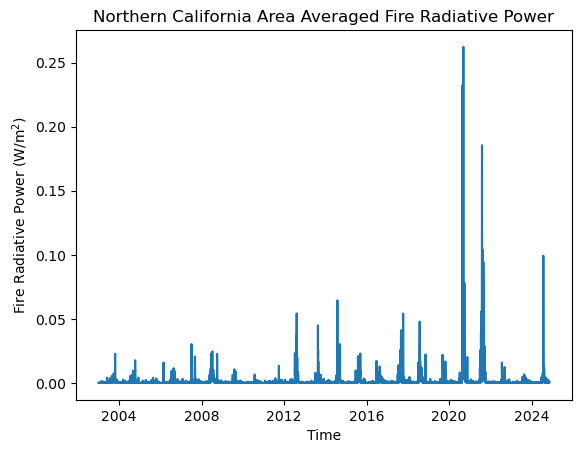

In [6]:
plt.plot(norcal_frp.coords['valid_time'].values, avgnorcal_frp_np)
plt.xlabel("Time")
plt.ylabel("Fire Radiative Power (W/m$^2$)")
plt.title("Northern California Area Averaged Fire Radiative Power")

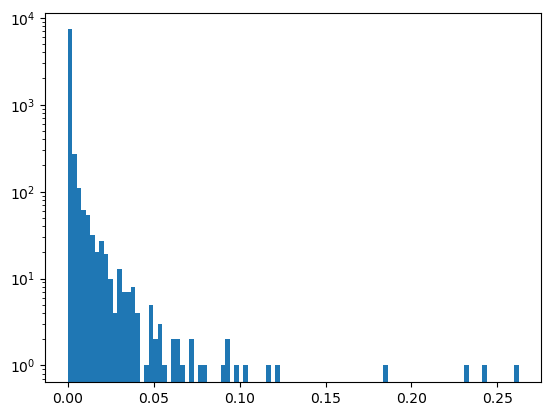

In [7]:
plt.hist(avgnorcal_frp_np, bins=100)
plt.yscale('log')

In [8]:
frp_percent_threshold = 0.97
frp_value_threshold = np.sort(avgnorcal_frp_np)[np.floor(avgnorcal_frp_np.size*frp_percent_threshold).astype(np.int32):][0]

In [9]:
bounded_frp = norcal_frp[avgnorcal_frp_np > frp_value_threshold]
bounded_frp
print(f"frp_value_threshold: {frp_value_threshold}, retaining {len(bounded_frp)} days.")

frp_value_threshold: 0.010387085199368916, retaining 239 days.


# Detrending and Feature Engineering

In [10]:
era5 = xr.open_mfdataset(str(root/"nc"/"era5"/"*.nc"), join="inner")
era5['z'] = era5['z'][:,0,:,:]
era5

<xarray.Dataset>
Dimensions:         (valid_time: 7994, latitude: 161, longitude: 241,
                     pressure_level: 1)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 2003-01-01 ... 2024-11-19
  * latitude        (latitude) float64 60.0 59.75 59.5 59.25 ... 20.5 20.25 20.0
  * longitude       (longitude) float64 -150.0 -149.8 -149.5 ... -90.25 -90.0
    number          int64 0
    expver          (valid_time) object dask.array<chunksize=(7994,), meta=np.ndarray>
  * pressure_level  (pressure_level) float64 500.0
Data variables:
    u10             (valid_time, latitude, longitude) float32 dask.array<chunksize=(1599, 33, 49), meta=np.ndarray>
    v10             (valid_time, latitude, longitude) float32 dask.array<chunksize=(1599, 33, 49), meta=np.ndarray>
    d2m             (valid_time, latitude, longitude) float32 dask.array<chunksize=(1599, 33, 49), meta=np.ndarray>
    t2m             (valid_time, latitude, longitude) float32 dask.array<chunksize=(1599, 33, 49), meta=np.ndarray>
    msl             (valid_time, latitude, longitude) float32 dask.array<chunksize=(1599, 33, 49), meta=np.ndarray>
    z               (valid_time, latitude, longitude) float32 dask.array<chunksize=(2665, 54, 81), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-25T12:40 GRIB to CDM+CF via cfgrib-0.9.1...

From feature engineering drop t2m and d2m. MSLP and h500 can be clustered.

In [11]:
vars_to_drop = ['t2m', 'd2m']

In [12]:
fullnames = {
    "z": "500hPa Geopotential Height",
    "t2m": "2m Air Temperature",
    "d2m": "2m Dew Point Temperature",
    "msl": "Mean Sea Level Pressure"
}

allvars = ['z', "t2m", "d2m", "msl"]

vars = [x for x in allvars if x not in vars_to_drop]
curr_fullnames = ""
for var in vars:
    curr_fullnames += fullnames[var] + ", "
curr_fullnames = curr_fullnames[:-2]

In [13]:
era5 = era5.drop_dims(['pressure_level'])
era5 = era5.drop_vars(['number', 'expver'])
era5_to_cluster = era5.drop_vars(['u10', 'v10'])
era5_to_cluster = era5_to_cluster.drop_vars(vars_to_drop)
era5_scaled_and_detrended = era5_to_cluster.copy()

In [14]:
def haversine(lon1, lat1, lon2, lat2):
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    return 2 * 6371 * np.arcsin(np.sqrt(a))

In [15]:
lonlon_syn, latlat_syn = np.meshgrid(era5.coords['longitude'].values, era5.coords['latitude'].values)
sa_syn = cu.sphere_surface_area(latlat_syn, lonlon_syn, 0.25)
area_weight = sa_syn / np.mean(sa_syn, axis=(0,1))

dw_min = 0.0
dw_min = 1/(1-dw_min)
distances = haversine(lonlon_syn, latlat_syn, norcal_center[0], norcal_center[1])
dist_weights = np.ones(shape=distances.shape) - (distances/(dw_min*np.max(distances)))

In [16]:
for var_name in era5_to_cluster.data_vars:
    values = era5_to_cluster[var_name].values
    weighted_values = values*area_weight*dist_weights
    long_term_detrended_weighted_values, _ = \
        tu.quadratic_detrend(weighted_values)
    long_term_seasonal_detrended_weighted_values, _ = \
        tu.seasonal_detrend(long_term_detrended_weighted_values)
    era5_scaled_and_detrended[var_name].values = long_term_seasonal_detrended_weighted_values

In [17]:
era5_frp_subset = era5_to_cluster.sel(valid_time=bounded_frp.coords['valid_time'].values)
era5_sad_frp_subset = era5_scaled_and_detrended.sel(valid_time=bounded_frp.coords['valid_time'].values)

In [18]:
X, shapes = vt.fields_to_rows(tuple(era5_sad_frp_subset[var_name].values for var_name in era5_sad_frp_subset.data_vars))

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
pca = PCA(n_components=0.95, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)
print(f"Reduced from {X.shape[1]} to {X_pca.shape[1]} features")

Reduced from 77602 to 33 features


# K-means

Choose kmeans++, n_iter=500, n_runs=10

In [21]:
k_init = 'k-means++'
k_iter = 1000
k_runs = 10

Starting Davies_Bouldin:


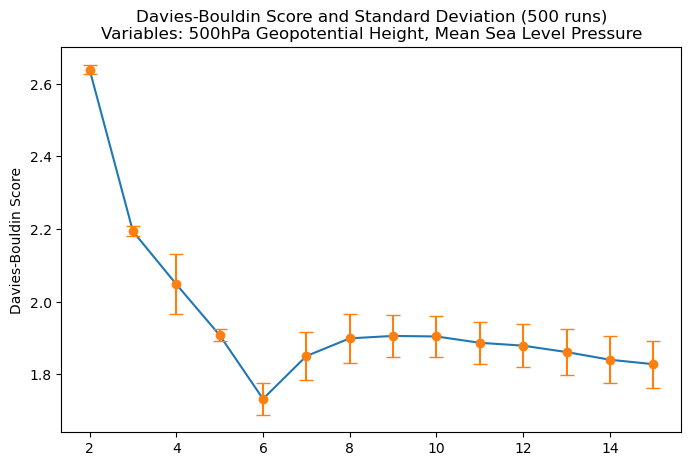

In [22]:
kmeans_errors_davies_bouldin = xr.DataArray(
    np.empty((14, 500)),
    dims=["k", "n"],
    coords={
        "k": np.arange(2, 16),
        "n": np.arange(500)
    }
)

print("Starting Davies_Bouldin:")
for k in kmeans_errors_davies_bouldin.coords["k"].values:
    for n in kmeans_errors_davies_bouldin.coords["n"].values:
        km = KMeans(n_clusters=k, init=k_init, n_init=k_runs, max_iter=k_iter)
        km.fit(X_pca)
        kmeans_errors_davies_bouldin.loc[k, n] = km.inertia_
        kmeans_errors_davies_bouldin.loc[k, n] = davies_bouldin_score(X_pca, km.labels_)

plt.figure(figsize=(8, 5))
line, = plt.plot(kmeans_errors_davies_bouldin.coords["k"].values, np.mean(kmeans_errors_davies_bouldin, axis=1), marker='.')
plt.errorbar(line.get_xdata(), line.get_ydata(), yerr=np.std(kmeans_errors_davies_bouldin, axis=1), fmt='o', capsize=5)
plt.ylabel("Davies-Bouldin Score")
plt.title("Davies-Bouldin Score and Standard Deviation (500 runs)\nVariables: " + curr_fullnames)
    
plt.show()

In [23]:
k = 5
random_state=123

In [24]:
def gmean(arr, axis=None):
    return np.exp(np.log(arr).mean(axis=axis))

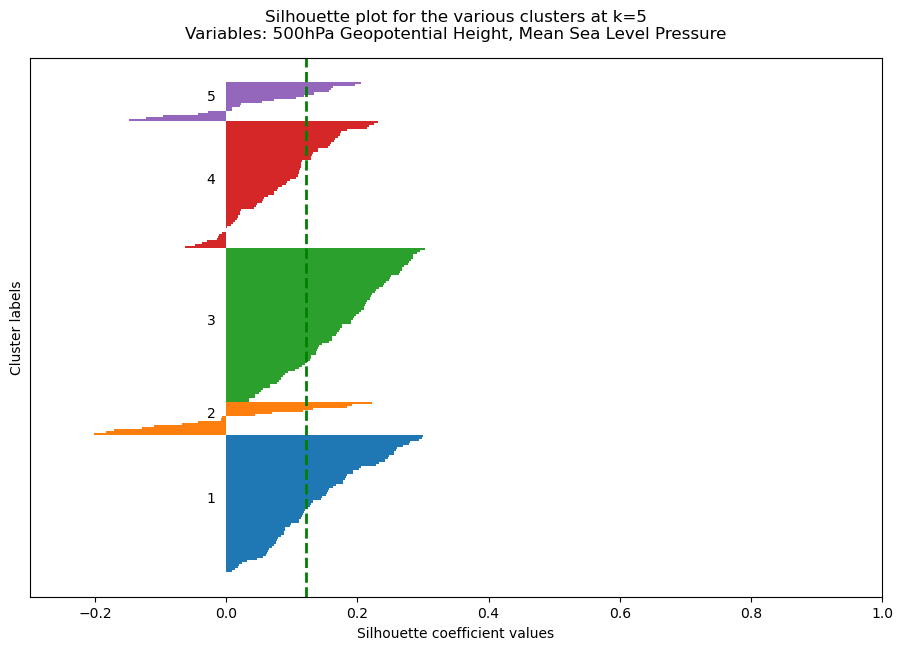

In [25]:
fig = plt.figure()
ax1 = plt.axes()
fig.set_size_inches(11, 7)

# Run the Kmeans algorithm with our hyperparameters and get label to silhouette analysis
km = KMeans(n_clusters=k, init=k_init, n_init=k_runs, max_iter=k_iter, random_state=random_state)
labels = km.fit_predict(X_pca)

# Get silhouette samples
silhouette_vals = silhouette_samples(X_pca, labels)

all_silhouette_vals = []
silhouette_frp = []
for i, cluster in enumerate(np.unique(labels)):
    #subset to get only the values from our current cluster
    cluster_silhouette_vals = silhouette_vals[labels == cluster]
    cluster_silhouette_vals.sort()
    all_silhouette_vals.append(cluster_silhouette_vals)
    meanfrp = gmean(np.mean(bounded_frp[labels == cluster].values, axis=(1,2)))
    silhouette_frp.append(meanfrp)

# print(silhouette_frp)
# print(all_silhouette_vals)
# print(sorted(list(zip(frp, all_silhouette_vals)), key=lambda x: x[0], reverse=True))

y_lower, y_upper = 0, 0
for i, cluster in enumerate(sorted(list(zip(silhouette_frp, all_silhouette_vals)), key=lambda x: x[0], reverse=True)):
    y_upper += len(cluster[1])
    #plot and add label
    ax1.barh(range(y_lower, y_upper), cluster[1], edgecolor='none', height=1)
    ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
    #set the lower bound for the next cluster
    y_lower += len(cluster[1])

# Get the average silhouette score and plot it
avg_score = np.mean(silhouette_vals)
ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
ax1.set_yticks([])
ax1.set_xlim([-0.3, 1])
ax1.set_xlabel('Silhouette coefficient values')
ax1.set_ylabel('Cluster labels')
ax1.set_title(f'Silhouette plot for the various clusters at k={k}\nVariables: ' + curr_fullnames, y=1.02)

plt.show()

In [26]:
km = KMeans(n_clusters=k, init=k_init, n_init=k_runs, max_iter=k_iter, random_state=random_state)
km.fit(X_pca)

KMeans(max_iter=1000, n_clusters=5, n_init=10, random_state=123)

In [27]:
separated_clusters = []
separated_clusters_allvars = []
clusters = {
    "k": [], 
    "coords": {
        'lat_syn': era5_frp_subset.coords['latitude'].values,
        'lon_syn': era5_frp_subset.coords['longitude'].values,
        'lat_frp': norcal_frp.coords['latitude'].values,
        'lon_frp': norcal_frp.coords['longitude'].values
    }
}

for i in range(k):
    times = era5_frp_subset.coords["valid_time"][km.labels_ == i]
    cluster = era5_frp_subset.sel(valid_time=times)
    fullcluster = era5.sel(valid_time=times)
    separated_clusters.append(cluster)
    separated_clusters_allvars.append(fullcluster)
    center = {}
    for var in cluster.data_vars:
        center[var] = np.mean(cluster[var].values, axis=0)
    cluster = {
        "center": center,
        "full": fullcluster,
        "n_cases": len(times),
        "times": times,
        "frp": bounded_frp[km.labels_ == i].values
    }
    clusters["k"].append(cluster)

clusters["k"].sort(key=lambda x: gmean(np.mean(x['frp'], axis=(1,2))), reverse=True)
clusters["k"][0]['center']['msl'].shape

(161, 241)

In [28]:
z500min = 530
z500max = 580

mslpmin = 1000
mslpmax = 1030

5


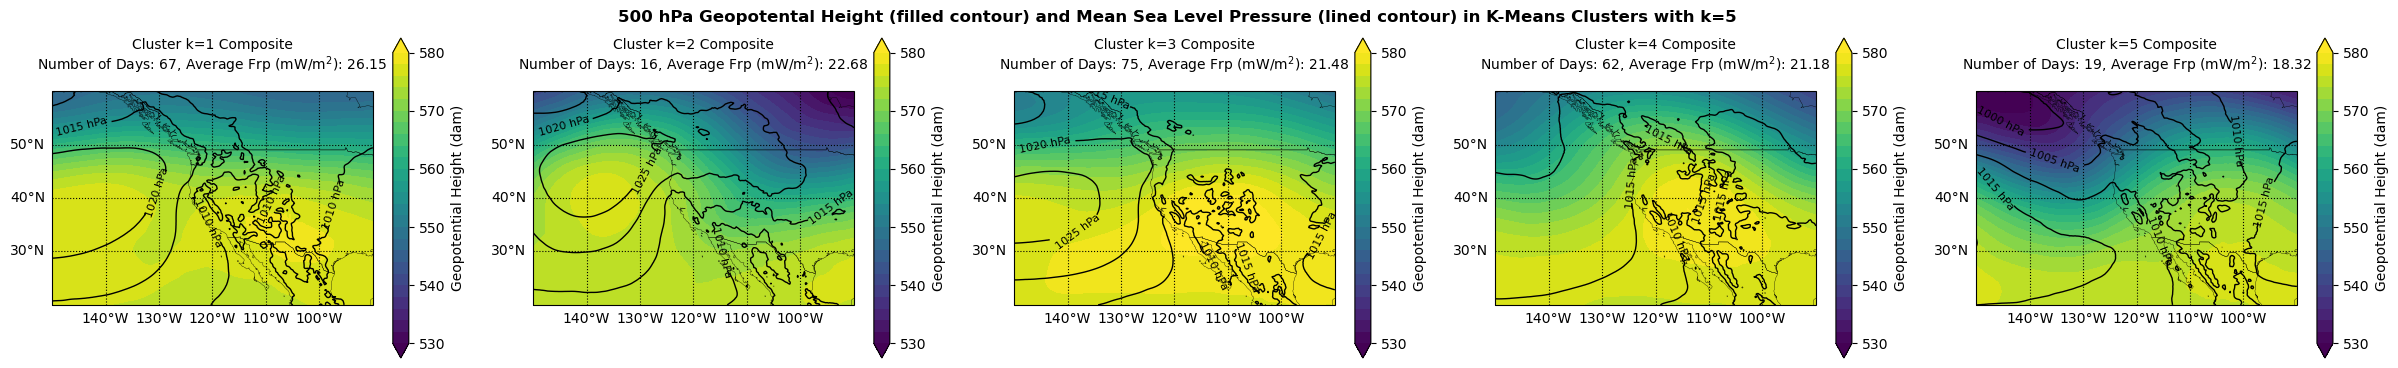

In [29]:
total_k = k
print(total_k)
fig = plt.figure(figsize=(30, 4))
for i, centroid in enumerate(clusters["k"]):
    k=i+1

    centers = centroid["center"]
    ax = plt.subplot(1, 5, k, projection=ccrs.PlateCarree())
    ax.axis('scaled')
    ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m'), linewidth=0.25, facecolor='none', edgecolor='black', zorder=2)
    ax.set_extent(synoptic_domain, crs=ccrs.PlateCarree())
    
    hgt_cont = ax.contourf(lonlon_syn, latlat_syn, centers['z']/100, range(z500min, z500max+1, 2), extend='both')
    cb = fig.colorbar(hgt_cont, ticks = range(z500min, z500max+1, 10), extend='both')
    cb.update_ticks()
    cb.set_label("Geopotential Height (dam)")

    mslp_cont = ax.contour(lonlon_syn, latlat_syn, centers['msl']/100, range(mslpmin, mslpmax+1, 5), linewidths=1, colors='black')
    ax.clabel(mslp_cont, range(mslpmin, mslpmax+1, 5), inline=True, fmt = lambda x: f"{round(x)} hPa", fontsize=8)

    gl_interval = 10
    gl = ax.gridlines(color="black", linestyle="dotted", draw_labels=True, x_inline=False, y_inline=False)
    gl.xlocator = plt.MultipleLocator(gl_interval)
    gl.ylocator = plt.MultipleLocator(gl_interval)
    gl.right_labels=False
    gl.top_labels=False
    gl.rotate_labels=False
    
    ax.set_title(f"Cluster k={k} Composite\n" + f"Number of Days: {centroid['n_cases']}, Average Frp (mW/m$^2$): {gmean(np.mean(centroid['frp']*1000, axis=(1,2))):.2f}", pad=15, size=10)
    
plt.subplots_adjust(top=0.91)
fig.suptitle(f"500 hPa Geopotental Height (filled contour) and Mean Sea Level Pressure (lined contour) in K-Means Clusters with k={total_k}", weight='bold')
plt.show()

In [30]:
with open(root/'clusters.pkl', 'wb') as f:
    pickle.dump(clusters, f)